# Twitter Sentiment Analysis

**Useful links**

* Twitter Developers: https://developer.twitter.com/en/portal/dashboard

* Check specific tweet based on tweet_id: https://twitter.com/papaemman_pan/status/tweet_id

* Find user name based on author_id: https://tweeterid.com/

* Similar use-case: https://github.com/julesz12345/Cryptocurrency-Prediction/blob/main/Code.ipynb

In [1]:
# Load libraries
import numpy as np
import pandas as pd
from pandas import json_normalize
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(13,6)})

import plotly.express as px

## Load data

In [3]:
# Load dataset

# datafile = "../data/ETH_twitter_api.csv"
# datafile = "../data/NMR_twitter_api.csv"
datafile = "../data/audio_twitter_api.csv"

tweets_df = pd.read_csv(datafile)

In [4]:
tweets_df = tweets_df.drop_duplicates()

In [5]:
# Check shape
tweets_df.shape

(86510, 8)

In [6]:
# Check dataset
tweets_df.head()

author_id                 created_at             tweet_id  \
0  1401095996520677381  2021-08-30 23:55:45+00:00  1432492267772723200   
1           2439046681  2021-08-30 23:49:46+00:00  1432490760327372803   
2   744638096428441600  2021-08-30 23:42:49+00:00  1432489012153946114   
3  1269391265403211777  2021-08-30 23:40:28+00:00  1432488418894884864   
4             54424724  2021-08-30 23:34:28+00:00  1432486910753067009   

                                                text  like_count  quote_count  \
0  MEME GAMES looks ready to pump x10 in 1 move 🚀...           3            0   
1  Monkey find, monkey share. 🍌 \n⁦@SolanaMBS⁩\n⁦...          13            3   
2  Pray for me baby Jesus. I just finished this @...           2            0   
3  #NewMusic makes a Monday a lot better!!-  #DRE...           1            0   
4  Ah! So good. Must listen today: @Cooopahtroopa...           0            0   

   reply_count  retweet_count  
0            1              1  
1           27              1  
2            0              1  
3            0              0  
4            0              1

In [7]:
# Check dataset
tweets_df.tail()

author_id                 created_at             tweet_id  \
86505  1034350481257066496  2020-01-01 06:51:10+00:00  1212264986313142272   
86506             65185407  2020-01-01 05:56:08+00:00  1212251136482299905   
86507             65185407  2020-01-01 05:55:34+00:00  1212250995381682177   
86508   942426492730036224  2020-01-01 02:09:11+00:00  1212194025983369223   
86509           3198619009  2020-01-01 00:31:18+00:00  1212169393024765953   

                                                    text  like_count  \
86505  Happy new year to my online family 2020 @Audiu...           7   
86506  THANKYOU ALL FOR SUPPORT OVER THE YEARS WITH S...           0   
86507  New music will now be releasing from now on us...           1   
86508  LOL audius has a vaporwave tag. that's crazy h...           3   
86509  MEMORIAL 2 ALL THA HOMMIZ \nHAPPY NEW YEARS\nB...           0   

       quote_count  reply_count  retweet_count  
86505            0            1              5  
86506            0            0              0  
86507            0            0              0  
86508            0            1              0  
86509            0            0              0

In [8]:
print("First date:", tweets_df["created_at"].min())
print("Last date:", tweets_df["created_at"].max())

First date: 2020-01-01 00:31:18+00:00
Last date: 2021-08-30 23:55:45+00:00


In [9]:
# Check Datatypes
tweets_df.dtypes

author_id         int64
created_at       object
tweet_id          int64
text             object
like_count        int64
quote_count       int64
reply_count       int64
retweet_count     int64
dtype: object

In [10]:
# Fix Data types
tweets_df["created_at"] = pd.to_datetime(tweets_df["created_at"], format ="%Y-%m-%d %H:%M:%S")

In [11]:
# Create new columns
tweets_df["created_at_date"] = tweets_df["created_at"].dt.date
tweets_df["created_at_date_hour"] = tweets_df["created_at"].dt.date.astype(str) + " " + tweets_df["created_at"].dt.hour.astype(str)

**Notes**

* The API respond data based on `created_at` timestamp. I can't query tweetes based on popularity using the Twitter API v2 (`result_type=popular` is not available).

## Add usernames (Optional - skip)

In [ ]:
import yaml
import requests
import json

def auth():
    with open("../config.yaml") as file:
        passwords = yaml.safe_load(file)
    return passwords["search_tweets_api"]["bearer_token"]

def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2UserLookupPython"
    return r

def connect_to_endpoint(url):
    response = requests.request("GET", url, auth=bearer_oauth,)
    # print(response.status_code)
    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(
                response.status_code, response.text
            )
        )
    return response.json()

def create_url(author_id):
    url = f"https://api.twitter.com/2/users/{author_id}?&user.fields=created_at,verified,public_metrics"
    return url

In [ ]:
## DEV 
bearer_token = auth()
url = create_url(1334365558259679238)
json_response = connect_to_endpoint(url)
print(json.dumps(json_response, indent=4, sort_keys=True))

In [ ]:
## Create the authors_df with info about author_id

unique_authors = tweets_df["author_id"].unique()

authors_df = pd.DataFrame()

for author_id in tqdm(unique_authors):
    url = create_url(author_id)
    json_response = connect_to_endpoint(url)
    author_id_row = json_normalize(json_response['data'])
    authors_df = authors_df.append(author_id_row)

In [ ]:
# Pre-process dataset
authors_df = authors_df[['id', 'username', 'name', 'verified',
                        'public_metrics.followers_count', 'public_metrics.following_count',
                        'public_metrics.tweet_count', 'public_metrics.listed_count',
                        'created_at']]

authors_df = authors_df.rename(columns={"id":"author_id", "created_at":"user_created_at"})

authors_df["author_id"] = authors_df["author_id"].astype(int)

In [ ]:
authors_df.head()

In [ ]:
# Merge authors_df with tweets_df dataset
tweets_df = tweets_df.merge(authors_df, on = "author_id", how="left")

## EDA

In [12]:
# Check columns
tweets_df.columns

Index(['author_id', 'created_at', 'tweet_id', 'text', 'like_count',
       'quote_count', 'reply_count', 'retweet_count', 'created_at_date',
       'created_at_date_hour'],
      dtype='object')

In [13]:
# What is the proportion of unique accounts
total_unique_accounts = tweets_df["author_id"].nunique()
print(f"There are {total_unique_accounts} unique accounts, on {len(tweets_df)} tweets ({np.round(total_unique_accounts/len(tweets_df),2)}%).")

There are 20338 unique accounts, on 86510 tweets (0.24%).


In [14]:
# Total number of tweets per Minute
print("Total number of tweets per Minute")
tweets_df["created_at"].dt.minute.value_counts().sort_index(ascending=False)

Total number of tweets per Minute


59    1366
58    1321
57    1273
56    1346
55    1293
54    1223
53    1437
52    1310
51    1276
50    1313
49    1307
48    1359
47    1551
46    1713
45    1329
44    1305
43    1290
42    1278
41    1287
40    1462
39    1989
38    1417
37    1268
36    1326
35    1555
34    1476
33    1460
32    1667
31    1842
30    1490
29    1341
28    1333
27    1313
26    1307
25    1373
24    1343
23    1341
22    1327
21    1269
20    1403
19    1275
18    1293
17    1456
16    1731
15    1430
14    1359
13    1383
12    1360
11    1788
10    1569
9     1903
8     1358
7     1384
6     1464
5     1570
4     1468
3     1650
2     1565
1     1796
0     1829
Name: created_at, dtype: int64

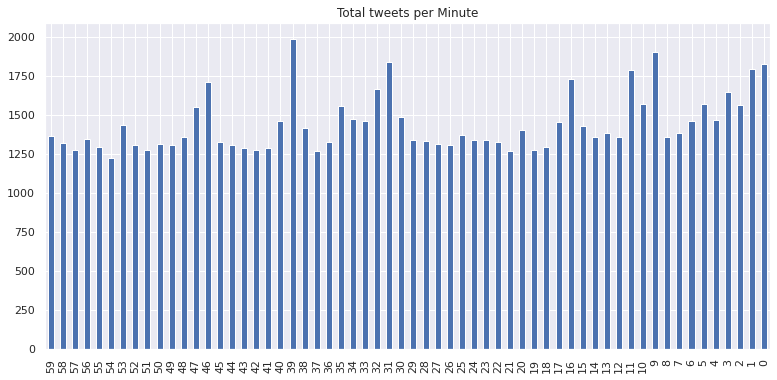

In [15]:
(tweets_df["created_at"]
 .dt.minute
 .value_counts()
 .sort_index(ascending=False)
 .plot.bar(title="Total tweets per Minute"));

**Non-uniform distribution per hour**

I query ~300 tweets per hour, using the Twitter API v2,
based on a certain keywords and conditions.
This means that for every hour I gather the relevant tweets but with chronological order, not based on popularity. So, as one can see in the distribution, the vast majority of tweets lies in the later half of the hour and I don't have much information about the first half.


**Possible Work-arounds:**

* Query based on popularity and not chronologicaly (doesn't supported in Twitter API v2).
* write more specific queries to exclude irrelevant tweets
* Query tweets from specific accounts only
* Query all tweets

In [16]:
# Total number of tweets per Hour
print("Total number of tweets per Hour")
tweets_df["created_at"].dt.hour.value_counts().sort_index(ascending=True)

Total number of tweets per Hour


0     3714
1     3282
2     3079
3     2843
4     2925
5     2497
6     2463
7     2624
8     2504
9     2969
10    3104
11    3095
12    3213
13    3249
14    3828
15    4216
16    4792
17    4869
18    5126
19    4669
20    4632
21    4808
22    4150
23    3859
Name: created_at, dtype: int64

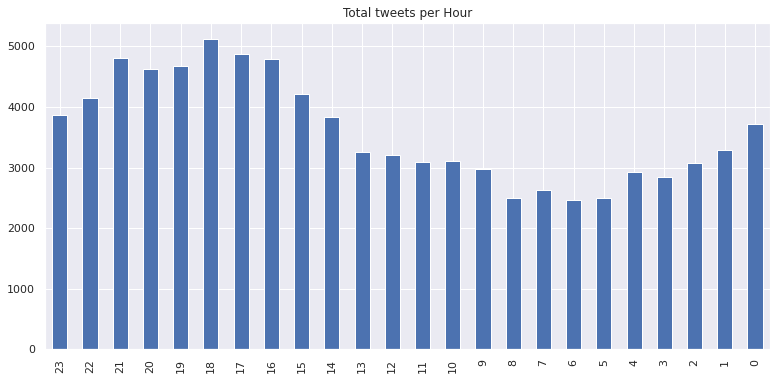

In [17]:
(tweets_df["created_at"]
 .dt.hour
 .value_counts()
 .sort_index(ascending=False)
 .plot.bar(title="Total tweets per Hour"));

In [18]:
# Total number of tweets per Date
print("Total number of tweets per Date")
tweets_df["created_at"].dt.date.value_counts().sort_index()

Total number of tweets per Date


2020-01-01     11
2020-01-02     20
2020-01-03     13
2020-01-04     14
2020-01-05     14
             ... 
2021-08-26    349
2021-08-27    306
2021-08-28    366
2021-08-29    355
2021-08-30    328
Name: created_at, Length: 608, dtype: int64

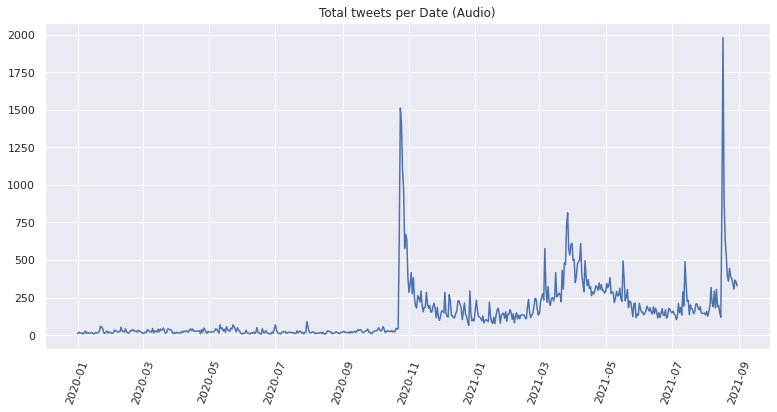

In [21]:
(tweets_df["created_at"]
 .dt.date
 .value_counts()
 .sort_index(ascending=True)
 .plot.line(title="Total tweets per Date (Audio)", rot=70));

In [22]:
# Total number of tweets per Date
print("Total number of tweets per Month")
tweets_df["created_at"].dt.month.value_counts().sort_index()

Total number of tweets per Month


1      4537
2      4853
3     12000
4     11749
5      9003
6      5220
7      6481
8     12014
9       680
10     8609
11     6473
12     4891
Name: created_at, dtype: int64

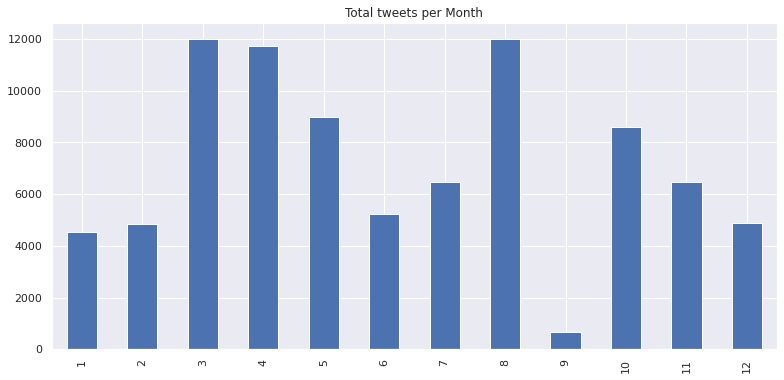

In [23]:
(tweets_df["created_at"]
 .dt.month
 .value_counts()
 .sort_index(ascending=True)
 .plot.bar(title="Total tweets per Month"));

In [24]:
# Descriptive Statistics: Tweet metrics
(tweets_df
 [["like_count", "quote_count", "reply_count", "retweet_count"]]
 .describe(percentiles=[x/100 for x in range(0,100,10)]))

like_count   quote_count   reply_count  retweet_count
count  86510.000000  86510.000000  86510.000000   86510.000000
mean       5.571044      0.168940      0.605121       1.164328
std       31.047030      2.264304      8.608383      11.892963
min        0.000000      0.000000      0.000000       0.000000
0%         0.000000      0.000000      0.000000       0.000000
10%        0.000000      0.000000      0.000000       0.000000
20%        0.000000      0.000000      0.000000       0.000000
30%        0.000000      0.000000      0.000000       0.000000
40%        1.000000      0.000000      0.000000       0.000000
50%        1.000000      0.000000      0.000000       0.000000
60%        2.000000      0.000000      0.000000       0.000000
70%        3.000000      0.000000      0.000000       0.000000
80%        4.000000      0.000000      0.000000       1.000000
90%        8.000000      0.000000      1.000000       3.000000
max     2599.000000    371.000000   1793.000000    1878.000000

**Conclusions**

Most of the tweets have **low to none impression** to community (likes, quotes, replies, retweets). But there are few tweets that are influencials and they attract the vast majority of community's attention.

In [25]:
# What's the minimum minute for every hour.
# If the minute is too high, we can conclude that there are many tweets this hour.

## WordCloud

In [26]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [27]:
# WordCloud?

In [28]:
# Concatanate tweets on a single string
text = " ".join(review for review in tweets_df["text"])
total_words = len(text)
print (f"There are {total_words} words in the combination of all tweets.")

# Lower case the words
text = text.lower()

unique_words = set(text)
total_unique_words = len(unique_words)
print (f"The unique words are {total_unique_words}")

There are 12486443 words in the combination of all tweets.
The unique words are 2098


In [29]:
# unique_words

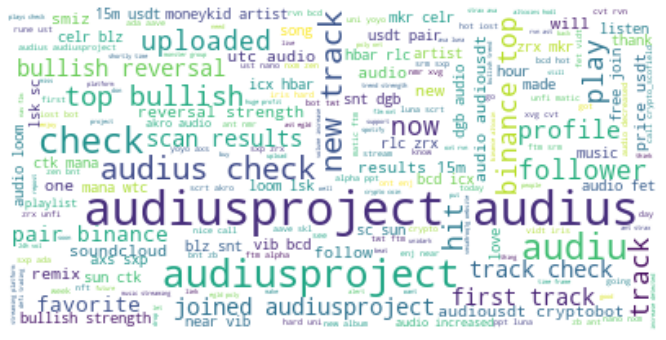

In [30]:
# Create stopword list and update it with other common words
stopwords = set(STOPWORDS)
stopwords.update(["ethereum","ether","eth", "bitcoin","btc",
                  "https","t", "u", "b s", "m", "gt","co",
                  "s","amp"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [31]:
# Most common words
wordcloud.words_

{'audiusproject audius': 1.0,
 'audiusproject': 0.6640776699029126,
 'audiu': 0.5279395900755124,
 'check': 0.5067961165048543,
 'new track': 0.3597626752966559,
 'audius check': 0.3518338727076591,
 'top bullish': 0.2696871628910464,
 'binance top': 0.22459546925566343,
 'play': 0.21893203883495146,
 'follower': 0.2074433656957929,
 'hit': 0.20285868392664508,
 'uploaded': 0.2011866235167206,
 'now': 0.19795037756202805,
 'track': 0.19147788565264293,
 'profile': 0.16024811218985976,
 'joined audiusproject': 0.1493527508090615,
 'first track': 0.1429881337648328,
 'scan results': 0.13592233009708737,
 'bullish reversal': 0.13435814455231931,
 'track check': 0.1290722761596548,
 'favorite': 0.11618122977346278,
 'pair binance': 0.11375404530744336,
 'reversal strength': 0.11186623516720604,
 'one': 0.11008629989212514,
 'new': 0.10846817691477886,
 'will': 0.10765911542610572,
 'smiz': 0.10566343042071197,
 'results 15m': 0.10323624595469255,
 'soundcloud': 0.10237324703344121,
 'audio

In [32]:
# from plotly_wordcloud import plotly_wordcloud as pwc
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected=True)
# iplot(pwc(text))

## Find Influencers

In [33]:
# "like_count", "quote_count", "reply_count", "retweet_count"
tweets_df.sort_values("like_count", ascending=False).head(5)

author_id                created_at             tweet_id  \
10068  1019723274693926912 2021-08-08 21:31:08+00:00  1424483340984274946   
8467   1019723274693926912 2021-08-16 16:00:39+00:00  1427299274325323779   
2421   1019723274693926912 2021-08-24 03:18:40+00:00  1430006616145874949   
28781            352518189 2021-05-04 14:48:28+00:00  1389592768750800900   
24103   951329744804392960 2021-05-20 17:04:11+00:00  1395425130830958599   

                                                    text  like_count  \
10068  🎧 NFT GIVEAWAY 🐵\n\nWe are excited to team up ...        2599   
8467   📢 Announcing the Audius TikTok integration! 📢\...        2486   
2421   Audius just crossed half a million track uploa...        1836   
28781  We’re exploring 12 new assets for the possibil...        1797   
24103  Welcome! If you’re new to Solana, take a tour ...        1653   

       quote_count  reply_count  retweet_count created_at_date  \
10068          371         1793           1848      2021-08-08   
8467           261          210            764      2021-08-16   
2421            36           80            230      2021-08-24   
28781          103          753            348      2021-05-04   
24103           56          125            447      2021-05-20   

      created_at_date_hour  
10068        2021-08-08 21  
8467         2021-08-16 16  
2421          2021-08-24 3  
28781        2021-05-04 14  
24103        2021-05-20 17

* There are plenty of popular tweets, which doesn't belong to colleted accounts in `twitter_accounts.txt` dataset.
* Check specific tweet based on tweet_id: https://twitter.com/papaemman_pan/status/tweet_id

In [34]:
# Filter tweets with low impression (without likes, retweets, retweets, replies)
threshold = 1_000
var = "like_count"

influencial_tweets_df = tweets_df.query(f" {var} > {threshold}")
print(f"There are {len(influencial_tweets_df)} tweets with more than {threshold} {var}")

There are 12 tweets with more than 1000 like_count


In [35]:
fig = px.line(influencial_tweets_df,
              x="created_at", y="like_count",
              title='Total likes for influencial tweets',
              hover_name="author_id", # username
              hover_data=["created_at", "like_count","tweet_id","text"])
fig.show()

# NLP

In [36]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

In [37]:
## Text preprocesing

# 1. lower_case
tweets_df['text'] = tweets_df['text'].str.lower()

## VADER

**Sentiment Analysis using VADER**

https://github.com/cjhutto/vaderSentiment

**`VADER` (Valence Aware Dictionary and sEntiment Reasoner)** is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. It is fully open-sourced under the [MIT License] (we sincerely appreciate all attributions and readily accept most contributions, but please don't hold us liable).

The **`compound score`** is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between **-1 (most extreme negative) and +1 (most extreme positive)**. This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

It is also useful for researchers who would like to **set standardized thresholds** for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

* **positive sentiment**: `compound score >= 0.05`
* **neutral sentiment**: `(compound score > -0.05) and (compound score < 0.05)`
* **negative sentiment**: `compound score <= -0.05`

NOTE: The compound score is the one most commonly used for sentiment analysis by most researchers, including the authors.

In [38]:
## // DEV: Experiment with VADER //

## Extract a sentense
sentence = (tweets_df
            .sort_values("like_count", ascending=False)
            .iloc[2]["text"])

print(sentence)

## VADER
sid_obj = SentimentIntensityAnalyzer()
sentiment_dict = sid_obj.polarity_scores(sentence)
print("Overall sentiment dictionary is : ", sentiment_dict)
print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")

audius just crossed half a million track uploads 🥳
Overall sentiment dictionary is :  {'neg': 0.0, 'neu': 0.776, 'pos': 0.224, 'compound': 0.3818}
sentence was rated as  0.0 % Negative
sentence was rated as  77.60000000000001 % Neutral
sentence was rated as  22.400000000000002 % Positive


In [39]:
tweets_df.head()

author_id                created_at             tweet_id  \
0  1401095996520677381 2021-08-30 23:55:45+00:00  1432492267772723200   
1           2439046681 2021-08-30 23:49:46+00:00  1432490760327372803   
2   744638096428441600 2021-08-30 23:42:49+00:00  1432489012153946114   
3  1269391265403211777 2021-08-30 23:40:28+00:00  1432488418894884864   
4             54424724 2021-08-30 23:34:28+00:00  1432486910753067009   

                                                text  like_count  quote_count  \
0  meme games looks ready to pump x10 in 1 move 🚀...           3            0   
1  monkey find, monkey share. 🍌 \n⁦@solanambs⁩\n⁦...          13            3   
2  pray for me baby jesus. i just finished this @...           2            0   
3  #newmusic makes a monday a lot better!!-  #dre...           1            0   
4  ah! so good. must listen today: @cooopahtroopa...           0            0   

   reply_count  retweet_count created_at_date created_at_date_hour  
0            1              1      2021-08-30        2021-08-30 23  
1           27              1      2021-08-30        2021-08-30 23  
2            0              1      2021-08-30        2021-08-30 23  
3            0              0      2021-08-30        2021-08-30 23  
4            0              1      2021-08-30        2021-08-30 23

In [40]:
# import swifter

Note that `swifter` will not work automatically for **string columns**. When using strings, Swifter will fallback to a “simple” Pandas apply, which will not be parallel. In this case, even forcing it to use dask will not create performance improvements, and you would be better off just splitting your dataset manually and parallelizing using multiprocessing.

In [41]:
## Calculate sentiment for each tweet

def extract_sentiment(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return sentiment_dict["compound"]

# Extract a sample of tweets
# tweets_df = tweets_df.sample(1000)
# tweets_df = tweets_df[:10_000]

tweets_df['sentiment'] = (tweets_df['text']
                          # .swifter.apply(lambda x: extract_sentiment(x))
                          .progress_apply(lambda x: extract_sentiment(x))
                         )

100%|██████████| 86510/86510 [12:22<00:00, 116.58it/s]


In [42]:
## Work-around: Create a random sentiment column
# tweets_df['sentiment'] = np.random.uniform(low=-1,high=1, size=len(tweets_df))

In [43]:
pd.set_option('display.max_colwidth', None)

In [44]:
# Most positive tweets
positive_tweets_df = (tweets_df
                      .sort_values("sentiment", ascending=False)
                      .head(5)
                      .sort_values("created_at")
                      [["author_id", "created_at", "text", "sentiment"]])
positive_tweets_df

author_id                created_at  \
80408  1137138301679394816 2020-09-18 17:44:23+00:00   
70658  1313877345711710208 2020-11-03 14:22:39+00:00   
22428             70493983 2021-05-28 17:52:02+00:00   
13563            437920651 2021-07-19 18:07:09+00:00   
12657   999074571105030144 2021-07-24 18:01:34+00:00   

                                                                                                                                                                                                                                                                                      text  \
80408                                                                   meu ep novo "blusky" ta online\n💙💙💙💙💙💙💙💙💙\n\ndeezer: https://t.co/99ihsmcvjn\nbandcamp: https://t.co/cou2jeasql\naudius: https://t.co/ziu7z2r1zn\nyoutube (topic): https://t.co/syyl0qhppp https://t.co/asxbw6yovp   
70658                                                                                    this is really awesome and flabbergasted project. i love this amazing project.  please share this project to everyone. 🤩🤑❤💞💓💗💕 @abdheshk248 @umeshku21855264 @bendine1976 https://t.co/er3swnpxes   
22428                                                                                                                                                            i just hit over 100 followers on @audiusproject #audius! https://t.co/qjrpz2fwhs thank you audius community. wow 🥰🥰🥰🥰🥰🥰🥰🥰   
13563  super grateful for this @audiusproject grant! 🎉🎉🎉\n\ndo i sense a remix competition for my next release coming up with $audio prizes? 🤔\n\ni definitely recommend applying for this grant, audius has been really great about supporting artist projects 🙏💜 https://t.co/kaplm0ql1c   
12657             i will give away 200 $sparta to one lucky follower if it touches $0.60 with in a week.\nconditions:\n* like this tweet.\n* retweet it\n* follow me \nbest of luck 😊😊😊😍😍😎😎\n$bnb $btc $sand $axs $dego $audio $tlm $link $rep $dexe $eth $doge $rvn $xrp $chr $ada $matic   

       sentiment  
80408     0.9911  
70658     0.9904  
22428     0.9966  
13563     0.9903  
12657     0.9909

In [45]:
# Most negative tweets
negative_tweets_df = (tweets_df
                      .sort_values("sentiment")
                      .head(5)
                      .sort_values("created_at")
                      [["author_id","created_at", "text", "sentiment"]])
negative_tweets_df

author_id                created_at  \
82363   945048358326099969 2020-06-13 09:39:33+00:00   
75283  1099065989168271361 2020-10-26 15:46:55+00:00   
45044   946752738997755905 2021-03-25 10:13:38+00:00   
11114  1033385937475055617 2021-08-03 20:27:38+00:00   
10792             34809990 2021-08-05 19:36:59+00:00   

                                                                                                                                                                                                                                                                         text  \
82363                                                                                        yapinnda out and exclusive to traxsource now!!!\n💥💥💥💥💥💥💥💥💥💥💥💥💥\n\nhttps://t.co/nhkrynijtg\n\n#yapinnda \n#afrohouse \n#dance \n#newrelease \n@traxsource https://t.co/s2wia7qnfl   
75283                                                                                                                                                                                                       im about to buy my dream guitar thanks to @audiusproject 😱😱😱😱😱😱😱😱   
45044                                                                                                                                                                                                     $audio does not care what the rest of the market does 🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥   
11114  ayo could twitter stop compressing all my previews so hard that it sounds like you're in a wind tunnel  😭😭😭😭😭😭😭😭😭😭😭😭\n\nyall ong i just gotta say that the twitter video of a song does not define its actualy quality, go peep the soundcloud/audius/youtube vers 😭🙏🏻   
10792                                                                                                                                                                       🔊🔉🔈🎶🎼✔️🕯🕯🕯🕯🕯🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥\n\ncrazy way crazy wave by i-juggle  on audius https://t.co/tblv0eubuq   

       sentiment  
82363    -0.9815  
75283    -0.9902  
45044    -0.9815  
11114    -0.9905  
10792    -0.9867

## Plots

In [46]:
# Extract most positive and most negative tweets and plot them
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=negative_tweets_df["created_at"],
                         y=negative_tweets_df["sentiment"],
                         mode='lines+markers',
                         text=negative_tweets_df['text'],
                         hovertemplate="<p>%{text}</p>",
                         name='Most Negative tweets',
                         line=dict(color='red')))

fig.add_trace(go.Scatter(x=positive_tweets_df["created_at"],
                         y=positive_tweets_df["sentiment"],
                         mode='lines+markers',
                         name='Most Positive tweets',
                         line=dict(color='green')))


fig.show()

In [47]:
# Γράφημα stacked bar plot για κάθε ημέρα πόσο είναι θετικό, πόσο αρνητικό, πόσο neutral
tweets_df["sentiment_val"] = pd.cut(tweets_df["sentiment"], bins = [-1, -0.05, 0.05, 1],
                                    labels=['negative', 'neutral', 'positive'])

sentiment_proportions = (tweets_df
                         .groupby("created_at_date_hour")
                         ["sentiment_val"]
                         .value_counts(normalize=True)
                         .to_frame())

sentiment_proportions = sentiment_proportions.rename(columns={"sentiment_val":"sentiment_proportions"})
sentiment_proportions = sentiment_proportions.reset_index()

In [48]:
sentiment_proportions.head(6)

created_at_date_hour sentiment_val  sentiment_proportions
0         2020-01-01 0      positive                    1.0
1        2020-01-01 16       neutral                    0.5
2        2020-01-01 16      positive                    0.5
3         2020-01-01 2      positive                    1.0
4        2020-01-01 20      positive                    1.0
5        2020-01-01 23       neutral                    0.5

In [49]:
fig = px.bar(sentiment_proportions[:3*22],
             x="created_at_date_hour",
             y="sentiment_proportions", color="sentiment_val",
             title="Proportion of sentiment per day",
            color_discrete_sequence=["lightgreen", "royalblue", "red"])

fig.show()

In [50]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=sentiment_proportions.query("sentiment_val=='positive'")["created_at_date_hour"],
                         y=sentiment_proportions.query("sentiment_val=='positive'")["sentiment_proportions"],
                         mode='lines+markers',
                         name='Positive tweets',
                         line=dict(color='lightgreen')))

fig.add_trace(go.Scatter(x=sentiment_proportions.query("sentiment_val=='neutral'")["created_at_date_hour"],
                         y=sentiment_proportions.query("sentiment_val=='neutral'")["sentiment_proportions"],
                         mode='lines+markers',
                         name='Neutral tweets',
                         line=dict(color='royalblue')))


fig.add_trace(go.Scatter(x=sentiment_proportions.query("sentiment_val=='negative'")["created_at_date_hour"],
                         y=sentiment_proportions.query("sentiment_val=='negative'")["sentiment_proportions"],
                         mode='lines+markers',
                         name='Negative tweets',
                         line=dict(color='red')))

fig.update_layout(title='Proportion of sentiment in tweets',
                   xaxis_title='Date',
                   yaxis_title='Proportion')

fig.show()

# Store Final Dataset

In [51]:
tweets_df.head()

author_id                created_at             tweet_id  \
0  1401095996520677381 2021-08-30 23:55:45+00:00  1432492267772723200   
1           2439046681 2021-08-30 23:49:46+00:00  1432490760327372803   
2   744638096428441600 2021-08-30 23:42:49+00:00  1432489012153946114   
3  1269391265403211777 2021-08-30 23:40:28+00:00  1432488418894884864   
4             54424724 2021-08-30 23:34:28+00:00  1432486910753067009   

                                                                                                                                                                                                                                                                                                                    text  \
0  meme games looks ready to pump x10 in 1 move 🚀\n\n➡️ 2m mcap\n\n🌐https://t.co/6tohi2a4r0 \n\nhttps://t.co/b5nwofceyz\n\n$audio $mana $joe $cgg $pvu $ufo $axs $shib $enj $alice $rare $zoo $ern $ilv $ygg $super $egld #nft #gamefi $tower $mbox $skill $torn $sol $sps $spell $erowan $ntvrk https://t.co/xamiwwoabu   
1                                                                                                                                                                                                    monkey find, monkey share. 🍌 \n⁦@solanambs⁩\n⁦@monke_dao⁩\n\nmonkeys chill by smb on audius https://t.co/yl241zfzoo   
2                                                                                                                                                                       pray for me baby jesus. i just finished this @kayzomusic remix for the comp and oof i hope they like it.\ncheck it out on audius september 2nd!!   
3                                                                           #newmusic makes a monday a lot better!!-  #dreams \n\n#jeauxydee #singers #beats #pop #guitar #piano #videos #insta @jonasbrothers @marshmellomusic @harry_styles @shawnmendes @beatstars @audiusproject @soundcloud https://t.co/rz2izghtzb   
4                                                                                                                                                                                                      ah! so good. must listen today: @cooopahtroopa @indexcoop @audiusproject #dao #nft $index https://t.co/4krlde63kn   

   like_count  quote_count  reply_count  retweet_count created_at_date  \
0           3            0            1              1      2021-08-30   
1          13            3           27              1      2021-08-30   
2           2            0            0              1      2021-08-30   
3           1            0            0              0      2021-08-30   
4           0            0            0              1      2021-08-30   

  created_at_date_hour  sentiment sentiment_val  
0        2021-08-30 23     0.6597      positive  
1        2021-08-30 23     0.2960      positive  
2        2021-08-30 23     0.8065      positive  
3        2021-08-30 23     0.7339      positive  
4        2021-08-30 23     0.5400      positive

In [52]:
## Store the final dataset (Try pickle, parquet)

tweets_df.to_csv("../data/AUDIO_twitter_api_sentiment.csv", index=False)

# Pickle
# tweets_df.to_pickle("../data/tweets_df_sentiment.pkl")
# tweets_df.to_pickle("../data/numerai_tweets_df_sentiment.pkl")